In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

In [5]:
X_train = pd.read_csv('train.csv', delimiter=',')
X_test = pd.read_csv('test.csv', delimiter=',')
print(f'Train set shape:{X_train.shape}, Test set shape:{X_test.shape}')

Train set shape:(891, 12), Test set shape:(418, 11)


In [6]:
#переглянемо наявні в обох наборах колонки
print(f'Train set columns: {X_train.columns}\n Test set columns: {X_test.columns}')

Train set columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
 Test set columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [7]:
#оскільки фіча Survived використовується для класифікації, видалимо її
X_train.drop(columns=['Survived'], inplace=True)
X_train.shape

(891, 11)

In [8]:
X = pd.concat([X_train, X_test], ignore_index=True)
X.shape

(1309, 11)

In [9]:
#оглянемо загальну статистику для набору даних
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [10]:
#перевіримо набір даних на дублікати
if X.duplicated().sum() > 0:
    print('There are duplicates!')
else:
    print('There are no duplicates!')

There are no duplicates!


In [11]:
#поглянемо на missing values
mis_val = X.isnull().sum()
mis_val = mis_val[mis_val != 0]
mis_val_percent = (mis_val / X.shape[0] * 100).apply(lambda x: np.round(x,2))
result = pd.concat([mis_val, mis_val_percent], axis=1).rename(columns={0:'№ of missing values', 1:'Fraction in %'})
display(result)

,№ of missing values,Fraction in %
Age,263,20.09
Fare,1,0.08
Cabin,1014,77.46
Embarked,2,0.15


In [12]:
#у колонці Cabin занадто багато відсутніх значень, тому видалимо її з датасету
#також видалимо колонку passengerid оскільки вона не надає додаткової логіки алгоритму, а лише вказує номер пасажира у списку
X.drop(columns=['Cabin','PassengerId'], inplace=True)
print(f'Dataset shape: {X.shape}')

Dataset shape: (1309, 9)


In [13]:
#поглянемо на типи даних наявні в датасеті
X.dtypes.value_counts()

object     4
int64      3
float64    2
dtype: int64

In [14]:
#дослідимо категоріальні фічі
categorical_columns = X.loc[:, X.dtypes == 'object'].columns
freq = []
for col in categorical_columns:
    freq.append(X[col].nunique())
categorical_columns = pd.concat([pd.Series(categorical_columns), pd.Series(freq)], axis=1).rename(columns={0:'Categorical feature', 1:'#unique values'})
categorical_columns

,Categorical feature,#unique values
0,Name,1307
1,Sex,2
2,Ticket,929
3,Embarked,3


In [15]:
#як багато з них має відсутні значення
print(f"Missing categorical values in Dataset: \n{X[['Name', 'Sex', 'Ticket', 'Embarked']].isnull().sum()}")

Missing categorical values in Dataset: 
Name        0
Sex         0
Ticket      0
Embarked    2
dtype: int64


In [16]:
#Заповнимо 2 відсутні значення медіаною, оскільки працюємо з категоріальною колонкою
most_freq = X['Embarked'].mode()[0]
X['Embarked'].fillna(most_freq, inplace=True)

In [17]:
#для колонки Sex застосуємо Label Encoding, а для всіх інших One-Hot Encoding
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
X['Sex'] = class_le.fit_transform(X['Sex'])

X = pd.get_dummies(X)

In [18]:
#перевіримо к-ть фіч після енкодингу
print(f'Dataset has {X.shape[1]} features')

Dataset has 2245 features


In [19]:
#усі колонки які лишились з відсутніми значеннями заповнимо медіаною, оскільки пізніше виконуватимемо стандартизацію
mis_val = X.isnull().sum()
mis_val = mis_val[mis_val != 0]
for col in mis_val.index:
    median = X[col].median()
    X[col].fillna(median, inplace=True)

In [20]:
#проведемо стандартизацію фіч, щоб деякі з них не впливали на алгоритм кластеризації сильніше
from sklearn.preprocessing import StandardScaler
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
sc = StandardScaler()
X[features] = sc.fit_transform(X[features])
X.head(15)

,Pclass,Sex,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)",...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.841916,1,-0.581628,0.481288,-0.445000,-0.503291,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1.546098,0,0.658652,0.481288,-0.445000,0.734744,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.841916,0,-0.271558,-0.479087,-0.445000,-0.490240,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1.546098,0,0.426099,0.481288,-0.445000,0.383183,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.841916,1,0.426099,-0.479087,-0.445000,-0.487824,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.841916,1,-0.116523,-0.479087,-0.445000,-0.479930,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,-1.546098,1,1.898932,-0.479087,-0.445000,0.359257,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0.841916,1,-2.131979,2.402037,0.710763,-0.235995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0.841916,0,-0.194041,-0.479087,1.866526,-0.428210,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,-0.352091,0,-1.201768,0.481288,-0.445000,-0.062068,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Text(0.5, 1.0, 'Elbow Method')

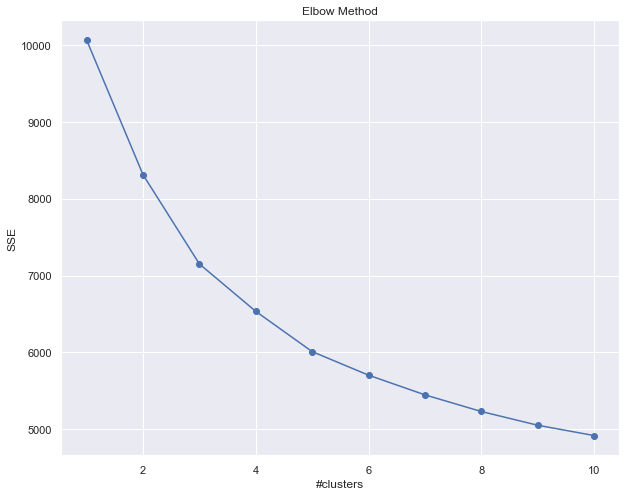

In [21]:
#методом ліктя визначимо прийнятну кількість кластерів
from sklearn.cluster import KMeans
from tqdm import tqdm
distortions = []
for i in tqdm(range(1,11)):
    class_km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-05, random_state=0)
    class_km.fit(X)
    distortions.append(class_km.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('#clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')

In [22]:
#оберемо кількість кластерів рівну 3
class_km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-05, random_state=0)
labels = class_km.fit_predict(X)

In [23]:
#виконаємо dimensionality reduction у 2D
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

In [24]:
#спроектуємо центри кластерів у 2D
centroids = pca_2d.transform(class_km.cluster_centers_)

Text(0.5, 1.0, 'ClusterDistribution')

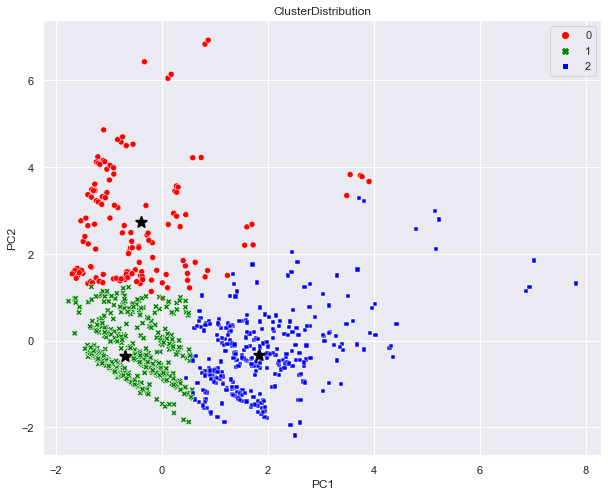

In [25]:
#тепер зобразимо кластери
from matplotlib.colors import ListedColormap
plt.figure(figsize=[10,8])
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, palette=ListedColormap(['red','green','blue']), style=labels)
plt.scatter(centroids[:,0], centroids[:,1], s=120, c='black', marker='*', linewidths=2, edgecolors='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ClusterDistribution')